In [1]:
from IPython.display import display
from IPython.display import Image
from utils import * # Code shared across more than one notebook

# A Python tutorial on validating gVirtualXRay:
## Analytic simulation vs. Monte Carlo simulation
### With a realistic beam spectrum and taking into account the energy response of the detector
#### Authors: T. Wen, A. Sujar and F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to real images from the [Visible Human Project (VHP)](https://www.nlm.nih.gov/research/visible/visible_human.html). We take into account i) a realistic beam spectrum and ii) the energy response of the detector.

**Material and Methods:** We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). <!--The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).-->

In [2]:
Image(filename="plots/lungman_model.png")

**Results:** The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is 58.48%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.2985**. 

The calculations were performed on the following platform:

In [3]:
printSystemInfo()

OS:
	Linux 5.3.18-lp152.20.7-default
	x86_64

CPU:
 	Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz

RAM:
	31 GB
GPU:
	Name: NVIDIA GeForce RTX 2080 Ti
	Drivers: 470.42.01
	Video memory: 11 GB


## Import packages

In [4]:
%matplotlib inline

import os # Locate files
from time import sleep

import datetime
import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient
from skimage.util import compare_images # Checkboard comparison between two images

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
# from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_error, mean_squared_error
import cv2

from tifffile import imread, imsave # Load/Write TIFF files

import viewscad # Use OpenSCAD to create STL files

# import pyvista as pv # 3D visualisation
# from pyvista import themes

# import cma # Optimise the parameters of the noise model

import k3d
import random
import base64
from stl import mesh

import urllib, gzip # To download the phantom data, and extract the corresponding Z file


import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook
import cma # Optimisation

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sys

SimpleGVXR 1.0.1 (2021-12-13T16:30:11) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-13T16:30:10) [Compiler: GNU g++] on Linux


In [5]:
def standardisation(img):
    return (img - img.mean()) / img.std()

## Reference image

We first load the DICOM file of the X-ray projection taken with the CT scanner.

In [6]:
sitk_image = sitk.ReadImage("lungman_data/CD2/DICOM/ST000000/SE000000/CT000000")
raw_reference = sitk.GetArrayFromImage(sitk_image)

raw_reference.shape = [raw_reference.shape[1], raw_reference.shape[2]]

raw_reference = raw_reference[0:448]
print(raw_reference.shape)

(448, 512)


In [7]:
imsave('gVirtualXRay_output_data/real_projection-lungman.tif', raw_reference.astype(np.single))

We plot the image using a linear look-up table and a power-law normalisation.

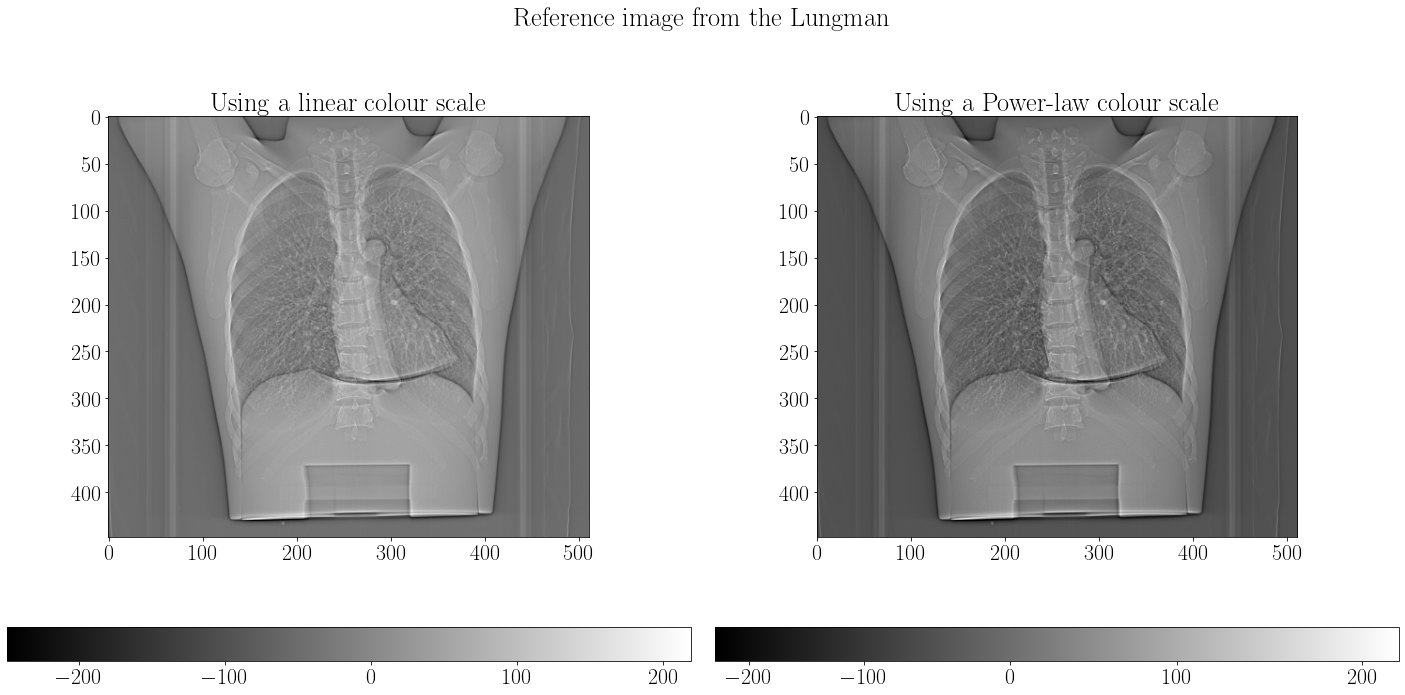

In [8]:
displayLinearPowerScales(raw_reference,
                         "Reference image from the Lungman",
                         "plots/reference-lungman-proj",
                         log=False)

Apply a log transformation

In [9]:
ground_truth = raw_reference
normalised_ground_truth = standardisation(ground_truth)

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [10]:
json2gvxr.initGVXR("notebook-13.json", "OPENGL")

Create an OpenGL context: 512x512
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 512 512


## X-ray source

We create an X-ray source. It is a point source.

In [11]:
json2gvxr.initSourceGeometry("notebook-13.json")

Set up the beam
	Source position: [0, 595, 0, 'mm']
	Source shape: PointSource


## Spectrum

The spectrum is polychromatic.

In [12]:
spectrum, unit, k, f = json2gvxr.initSpectrum("notebook-13.json", verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

params["Source"]["Beam"] {'kvp': 120, 'tube angle': 12, 'filter': [['Al', 3.2]]}
['Al', 3.2]


Plot the spectrum

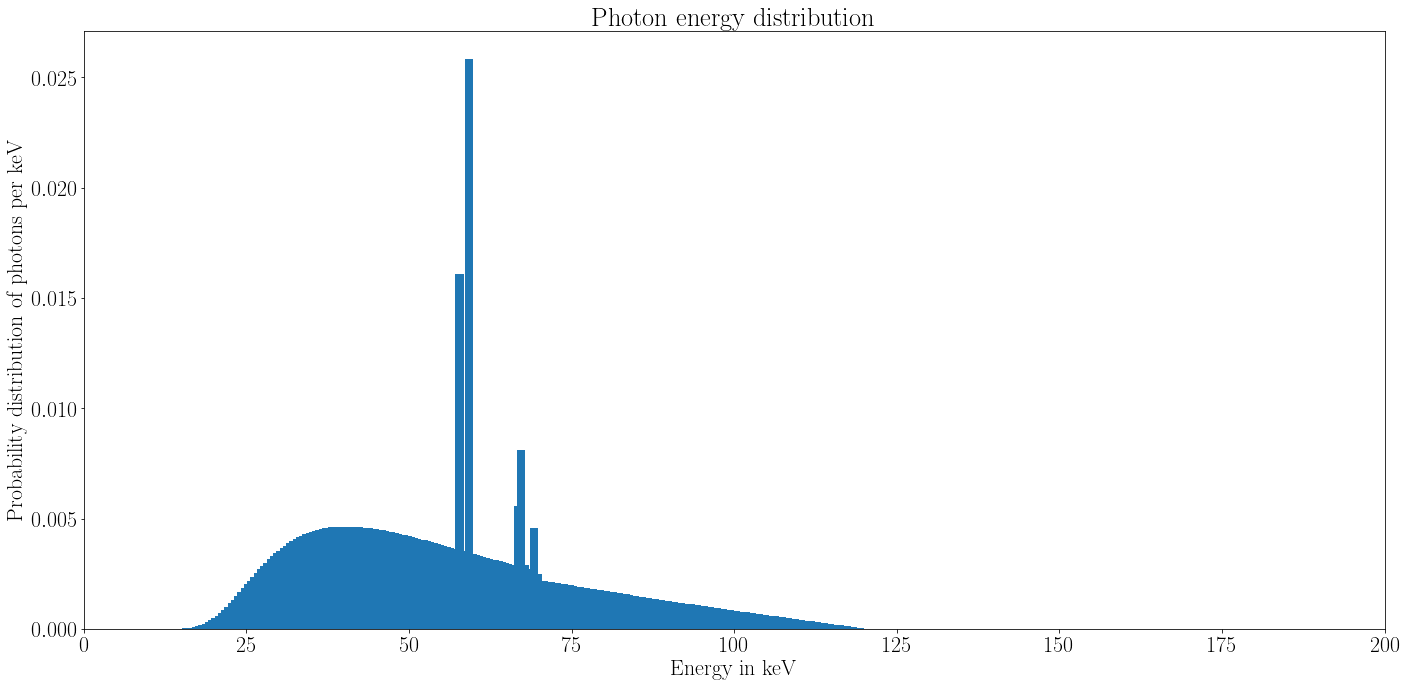

In [13]:
plotSpectrum(k, f, 'plots/spectrum-lungman-proj')

## Detector

Create a digital detector

In [14]:
json2gvxr.initDetector("notebook-13.json")

Set up the detector
	Detector position: [0, -490.6, 0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [512, 448]
	Energy response: Gate_data/responseDetector.txt in MeV
	Pixel spacing: [1, 1, 'mm']
INIT RENDER


## Sample

We now load the models segmented from the Visible Human.

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [15]:
json2gvxr.initSamples("notebook-13.json", verbose=0)

file_name:	lungman_data/meshes/tumours_100HU.stl	nb_faces:	2064	nb_vertices:	6192	bounding_box (in cm):	(-3.79375, -18.1687, -27.43)	(12.5188, -10.5437, -19.1)
file_name:	lungman_data/meshes/tumours_630HU.stl	nb_faces:	2550	nb_vertices:	7650	bounding_box (in cm):	(-9.79375, -16.7312, -27.57)	(6.14375, -11.1062, -13.15)
file_name:	lungman_data/meshes/clavicle.stl	nb_faces:	71130	nb_vertices:	213390	bounding_box (in cm):	(-11.5437, -19.9812, -10.42)	(13.1438, -9.41875, -4.12)
file_name:	lungman_data/meshes/heart.stl	nb_faces:	256732	nb_vertices:	770196	bounding_box (in cm):	(-1.85625, -21.7937, -29.6)	(10.3313, -10.0437, -10.14)
file_name:	lungman_data/meshes/bronchus.stl	nb_faces:	303038	nb_vertices:	909114	bounding_box (in cm):	(-10.5437, -21.4812, -30.79)	(12.5188, -6.98125, -8.39)
file_name:	lungman_data/meshes/diaphram.stl	nb_faces:	376416	nb_vertices:	1129248	bounding_box (in cm):	(-11.7937, -22.4187, -33.73)	(12.6438, -7.16875, -27.22)
file_name:	lungman_data/meshes/bronchioles.st

In [16]:
number_of_triangles = 0

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
    number_of_triangles += number_of_triangles_in_mesh
    
    print(label, \
          "has", \
          f"{number_of_triangles_in_mesh:,}", \
          "triangles.")

print("\nThere are", f"{number_of_triangles:,}", "triangles in total")

100HU_tumours has 2,064 triangles.
-630HU_tumours has 2,550 triangles.
Clavicle has 71,130 triangles.
Heart has 256,732 triangles.
Bronchus has 303,038 triangles.
Diaphram has 376,416 triangles.
Bronchioles has 2,340,602 triangles.
Ribs_Spine has 1,225,322 triangles.
Scapulas has 314,900 triangles.
Sheets_high has 341,010 triangles.
Sheets_low has 861,668 triangles.
Sheets_med has 879,096 triangles.
Skin has 3,964,164 triangles.
Sternum has 61,690 triangles.
Trachea has 48,770 triangles.

There are 11,049,152 triangles in total


# Visualise the virtual patient

In [17]:
# plot = k3d.plot()
# plot.background_color = 0xffffff

# for sample in json2gvxr.params["Samples"]:
    
#     label = sample["Label"]
    
#     fname = sample["Path"]

#     r, g, b, a = gvxr.getAmbientColour(label)
#     R = math.floor(255*r)
#     G = math.floor(255*g)
#     B = math.floor(255*b)
#     A = math.floor(255*a)

#     k3d_color = 0;
#     k3d_color |= (R & 255) << 16;
#     k3d_color |= (G & 255) << 8;
#     k3d_color |= (B & 255);

#     mesh_from_stl_file = mesh.Mesh.from_file(fname)

#     if label == "Skin":
#         opacity = 0.2
#     else:
#         opacity = 1
#     geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
#                           range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
#                           color=k3d_color, 
#                           wireframe=False, 
#                           flat_shading=False,
#                           name=fname,
#                           opacity=opacity)

#     plot += geometry   

# plot.display()
# plot.camera = [-331.9588958318764, -378.948200806186, -128.42416661488394, 67.59881627653458, -14.343638117004298, -203.16252140497986, 0.05481655383573701, 0.06127227589210948, 0.9966146966769794]

Output()

## Simulation with the default values

In [18]:
# Backup the transformation matrix
global_matrix_backup = gvxr.getSceneTransformationMatrix()

In [19]:
def getXRayImage():
    global total_energy_in_MeV

    # Compute the X-ray image
    xray_image = np.array(gvxr.computeXRayImage())
        
    # Flat-field
#     xray_image /= total_energy_in_MeV
    
    # Negative
    # x_ray_image = 1.0 - x_ray_image
    return xray_image #np.ones(xray_image.shape).astype(np.single) - xray_image

In [20]:
xray_image = getXRayImage()

In [21]:
# gvxr.enableArtefactFilteringOnCPU()
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix

In [22]:
# total_energy_in_keV = 0.0
# for energy, count in zip(energy_set, count_set):
#     effective_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])

#     total_energy_in_keV += effective_energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [23]:
xray_image = getXRayImage()

In [24]:
gvxr.displayScene()
gvxr.useNegative()

gvxr.setZoom(1339.6787109375)
gvxr.setSceneRotationMatrix([0.8227577805519104, 0.1368587613105774, -0.5516625642776489, 0.0, -0.5680444240570068, 0.23148967325687408, -0.7897683382034302, 0.0, 0.01961756870150566, 0.9631487131118774, 0.26820749044418335, 0.0, 0.0, 0.0, 0.0, 1.0])

gvxr.setWindowBackGroundColour(0.5, 0.5, 0.5)

gvxr.displayScene()

0 0 500 500
0 0 512 512


In [25]:
# gvxr.renderLoop()

In [26]:
# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

In [27]:
screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

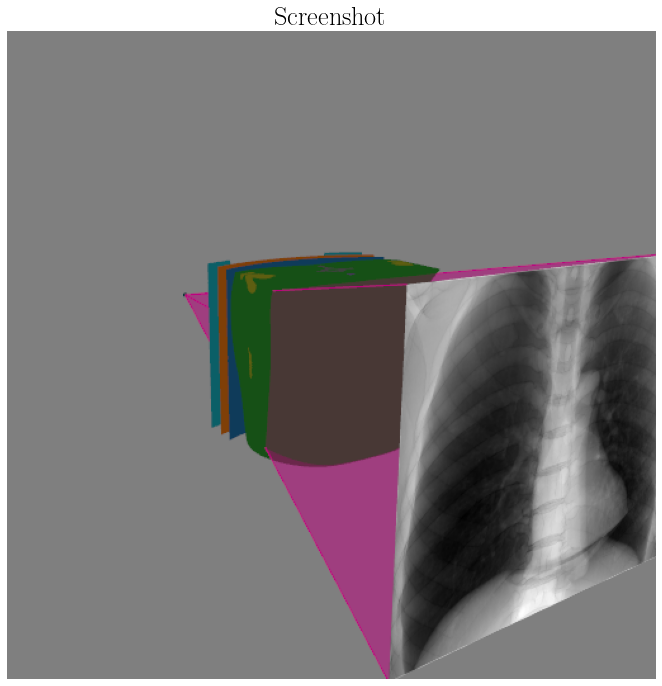

In [28]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/default-screenshot-beam-on-lungman.pdf')
plt.savefig('plots/default-screenshot-beam-on-lungman.png')

In [29]:
def logImage(xray_image: np.array, min_val: float, max_val: float) -> np.array:
    
    log_epsilon = 1.0e-9

    shift_filter = -math.log(min_val + log_epsilon)
    
    if min_val != max_val:
        scale_filter = 1.0 / (math.log(max_val + log_epsilon) - math.log(min_val + log_epsilon))
    else:
        scale_filter = 1.0

    corrected_image = np.log(xray_image + log_epsilon)

    return (corrected_image + shift_filter) * scale_filter

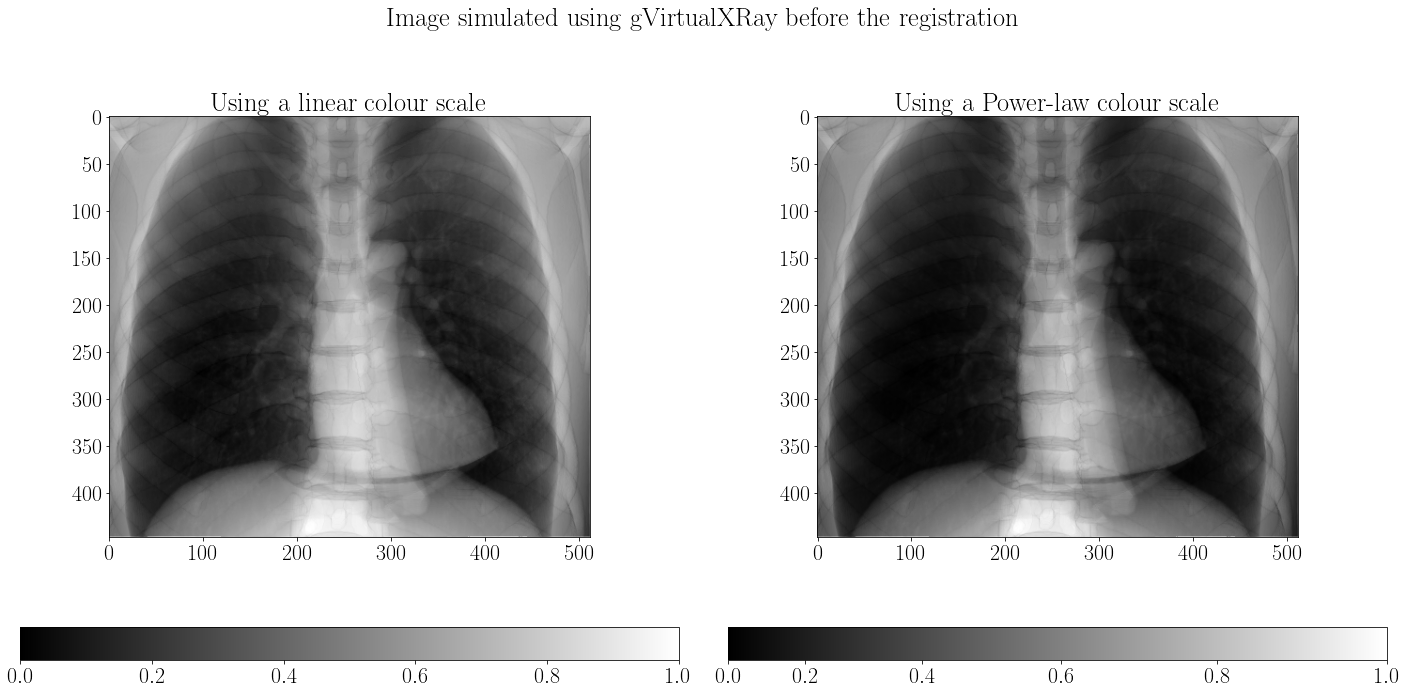

In [30]:
displayLinearPowerScales(1 - logImage(xray_image, xray_image.min(), xray_image.max()),
                         "Image simulated using gVirtualXRay before the registration",
                         "plots/gVirtualXRay-before_registration-lungman",
                         log=False)

## Registration

1st using CMA-ES with 5 different fitness functions, then using NSGA2 and NSGA3.

In [31]:
roi_ground_truth_min = ground_truth.min()
roi_ground_truth_max = ground_truth.max()
standardised_roi_ground_truth = standardisation(ground_truth)

imsave('gVirtualXRay_output_data/standardised_roi_ground_truth-lungman.tif', standardised_roi_ground_truth.astype(np.single))

In [32]:
source_position = gvxr.getSourcePosition("cm")
detector_position = gvxr.getDetectorPosition("cm")

x_init = [
    # Orientation of the sample
    0.0, 0.0,

    # Position of the source
    source_position[0],
    source_position[1],
    source_position[2],

    # Position of the detector
    detector_position[0],
    detector_position[1],
    detector_position[2]#,

    # Orientation of the detector
    #     det_rotation_angle1 = x[8]
    #     det_rotation_angle2 = x[9]

#         1.0 / 3.0, # c1
#         1.0, # gain1
#         0.0, # bias1

#         1.0 / 3.0, # c2
#         1.0, # gain2
#         0.0#, # bias2

#         1.0 / 3.0, # c3
#         1.0, # gain3
#         0.0, # bias3
#         2.0 # gamma
]

In [33]:
pos_offset = 20
angle_offset = 5

xl = [
            -angle_offset, -angle_offset, 
            source_position[0] - pos_offset, source_position[1] - pos_offset, source_position[2] - pos_offset,
            detector_position[0] - pos_offset, detector_position[1] - pos_offset, detector_position[2] - pos_offset#,
#             -90, -90, 
#             -10.0,
#             -10.0,
#             -10.0,

#             -10.0,
#             0.0,
#             0.0#,

#             -10.0,
#             -10.0,
#             -10.0,
#             0.0
        ]

xu = [
            angle_offset, angle_offset, 
            source_position[0] + pos_offset, source_position[1] + pos_offset, source_position[2] + pos_offset,
            detector_position[0] + pos_offset, detector_position[1] + pos_offset, detector_position[2] + pos_offset #,
#             90, 90, 
#             10.0,
#             10.0,
#             10.0,

#             10.0,
#             10.0,
#             10.0#,

#             10.0,
#             10.0,
#             10.0,
#             100.0
        ]

In [34]:
def setTransformations(x):
    # Orientation of the sample
    sample_rotation_angle1 = x[0]
    sample_rotation_angle2 = x[1]

    gvxr.rotateScene(sample_rotation_angle1, 1, 0, 0)
    gvxr.rotateScene(sample_rotation_angle2, 0, 1, 0)

    # Position of the source
    source_position_x = x[2]
    source_position_y = x[3]
    source_position_z = x[4]
    
    gvxr.setSourcePosition(
        source_position_x,
        source_position_y,
        source_position_z,
        "cm"
    )
    
    # Position of the detector
    det_position_x = x[5]
    det_position_y = x[6]
    det_position_z = x[7]
    
    gvxr.setDetectorPosition(
        det_position_x,
        det_position_y,
        det_position_z,
        "cm"
    )

    # Orientation of the detector
#     det_rotation_angle1 = x[8]
#     det_rotation_angle2 = x[9]    

In [35]:
def resetToDefaultParameters():
    json2gvxr.initDetector("notebook-13.json")
    json2gvxr.initSourceGeometry("notebook-13.json")
    source_position = gvxr.getSourcePosition("cm")
    detector_position = gvxr.getDetectorPosition("cm")

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(global_matrix_backup)

In [36]:
def updateXRayImage(x):
    
    
    # Backup the transformation matrix
    matrix_backup = gvxr.getSceneTransformationMatrix()

    # Set the transformations
    setTransformations(x)

    # Compute the X-ray image
    xray_image = getXRayImage()

#     gvxr.displayScene()
#     screenshot = gvxr.takeScreenshot()

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(matrix_backup)

    return xray_image #, screenshot

In [37]:
def applyLogScaleAndNegative(image: np.array) -> np.array:
    temp = logImage(image, image.min(), image.max())
    return 1.0 - temp

In [38]:
timeout_in_sec = 20 * 60 # 20 minutes

## CMA-ES

In [39]:
def objectiveFunction(x):
    
    global objective_function_string
    
    global ground_truth, standardised_roi_ground_truth
    global best_fitness, best_fitness_id, fitness_function_call_id, evolution_fitness, evolution_parameters


    xray_image = updateXRayImage(x)
    corrected_xray_image = applyLogScaleAndNegative(xray_image)
    standardised_corrected_xray_image = standardisation(corrected_xray_image)
    
    if objective_function_string == "zncc":
        zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
        dzncc = (1.0 - zncc) / 2.0
        objective = dzncc
    elif objective_function_string == "mae":
        mae = np.mean(np.abs(standardised_roi_ground_truth - standardised_corrected_xray_image))
        objective = mae
    elif objective_function_string == "rmse":
        rmse = math.sqrt(np.mean(np.square(standardised_roi_ground_truth - standardised_corrected_xray_image)))
        objective = rmse
    elif objective_function_string == "ssim":        
        ssim_value = ssim(standardised_roi_ground_truth, standardised_corrected_xray_image, data_range=standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
        dssim = (1.0 - ssim_value) / 2.0
        objective = dssim
    elif objective_function_string == "mape":
        # Avoid div by 0
        offset1 = min(standardised_roi_ground_truth.min(), standardised_corrected_xray_image.min())
        offset2 = 0.05 * (standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
        mape_value = mape(standardised_roi_ground_truth - offset1 + offset2, standardised_corrected_xray_image - offset1 + offset2)
        objective = mape_value

    if best_fitness > objective:
            
        evolution_fitness.append([fitness_function_call_id, objective])
        
        row = [fitness_function_call_id]
        for i in x:
            row.append(i)
        evolution_parameters.append(row)
        
        best_fitness = objective
    
    fitness_function_call_id += 1
    
    return objective

In [40]:
def optimiseWithCMAES(objective_function_str: str):

    global objective_function_string
    global best_fitness
    global best_fitness_id
    global fitness_function_call_id
    global evolution_fitness
    global evolution_parameters
    
    resetToDefaultParameters()

    objective_function_string = objective_function_str
    
    source_position = [0.0, 0.0, 0.0]
    detector_position = [0.0, 0.0, 0.0]


    if os.path.exists("gVirtualXRay_output_data/lungman-" + objective_function_string + ".dat") and \
        os.path.exists("gVirtualXRay_output_data/lungman_evolution-" + objective_function_string + ".dat") and \
        os.path.exists("gVirtualXRay_output_data/lungman_evolution_parameters-" + objective_function_string + ".dat"):
        
        temp = np.loadtxt("gVirtualXRay_output_data/lungman-" + objective_function_string + ".dat")
        
        sample_rotation_angle1 = temp[0]
        sample_rotation_angle2 = temp[1]
        source_position[0] = temp[2]
        source_position[1] = temp[3]
        source_position[2] = temp[4]
        detector_position[0] = temp[5]
        detector_position[1] = temp[6]
        detector_position[2] = temp[7]

        evolution_fitness = np.loadtxt("gVirtualXRay_output_data/lungman_evolution-" + objective_function_string + ".dat")
        evolution_parameters = np.loadtxt("gVirtualXRay_output_data/lungman_evolution_parameters-" + objective_function_string + ".dat")

    # CMA-ES
    else:

        opts = cma.CMAOptions()
        opts.set('tolfun', 1e-5)
        opts['tolx'] = 1e-5
        opts['timeout'] = timeout_in_sec
        opts['bounds'] = [xl, xu]

        opts['CMA_stds'] = []

        for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
            opts['CMA_stds'].append(abs(max_val - min_val) * 0.5)

        best_fitness = sys.float_info.max
        best_fitness_id = 0
        fitness_function_call_id = 0
        evolution_fitness = []
        evolution_parameters = []

        res = cma.fmin(objectiveFunction,
                  x_init,
                  0.5,
                  opts,
                  restarts=0)

        # Save the best individual
        sample_rotation_angle1 = res[0][0]
        sample_rotation_angle2 = res[0][1]
        source_position[0] = res[0][2]
        source_position[1] = res[0][3]
        source_position[2] = res[0][4]
        detector_position[0] = res[0][5]
        detector_position[1] = res[0][6]
        detector_position[2] = res[0][7]

        # Save best parameters from the optimiser
        answer = np.array([sample_rotation_angle1, sample_rotation_angle2, source_position[0], source_position[1], source_position[2], detector_position[0], detector_position[1], detector_position[2]])
        answer = answer.reshape(1, answer.shape[0])
        np.savetxt("gVirtualXRay_output_data/lungman-" + objective_function_string + ".dat",
                   answer,
                   header='sample_rotation_angle1, sample_rotation_angle2,source_pos_x,source_pos_y,source_pos_z,detector_pos_x,detector_pos_y,detector_pos_z')

        # Save the list of zncc for plotting
        evolution_fitness = np.array(evolution_fitness)
        np.savetxt("gVirtualXRay_output_data/lungman-evolution-" + objective_function_string + ".dat",
                   evolution_fitness,
                   header='t,' + objective_function_string)

        # Save the list of parameters for plotting
        evolution_parameters = np.array(evolution_parameters)
        print(evolution_parameters.shape)
        
        np.savetxt("gVirtualXRay_output_data/lungman-evolution_parameters-" + objective_function_string + ".dat",
                   evolution_parameters, 
                   header='t,sample_rotation_angle1,sample_rotation_angle2,source_pos_x,source_pos_y,source_pos_z,detector_pos_x,detector_pos_y,det_position_z')
    
    return [sample_rotation_angle1, sample_rotation_angle2, source_position[0], source_position[1], source_position[2], detector_position[0], detector_position[1], detector_position[2]], \
        evolution_fitness, \
        evolution_parameters

In [ ]:
objective_function_string = "zncc"
x_zncc, evolution_fitness_zncc, evolution_parameters_zncc = optimiseWithCMAES("zncc")

resetToDefaultParameters()
xray_image_zncc = applyLogScaleAndNegative(updateXRayImage(x_zncc))

Set up the detector
	Detector position: [0, -490.6, 0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [512, 448]
INIT RENDER
	Energy response: Gate_data/responseDetector.txt in MeV
	Pixel spacing: [1, 1, 'mm']
Set up the beam
	Source position: [0, 595, 0, 'mm']
	Source shape: PointSource
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=1026334, Mon Feb 14 16:14:33 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 3.346367855281782e-01 1.0e+00 4.64e-01  2e+00  9e+00 0:01.3
    2     20 2.794141647561435e-01 1.2e+00 4.43e-01  2e+00  9e+00 0:02.5
    3     30 3.052106385116800e-01 1.3e+00 4.43e-01  2e+00  9e+00 0:03.6
    6     60 3.049878911461708e-01 1.7e+00 4.05e-01  2e+00  9e+00 0:06.8
   10    100 2.840981121083203e-01 2.1e+00 3.57e-01  2e+00  7e+00 0:11.0
   15    150 2.818472379568067e-01 2.3e+00 2.98e-01  1e+00  6e+00 0:16.4
   21    210 2.650753501711645e-01 2.5e+00 1.80e-01  9e-01  3e+00 0:22.8
   28    280 2.54

In [ ]:
objective_function_string = "mae"
x_mae, evolution_fitness_mae, evolution_parameters_mae = optimiseWithCMAES("mae")

resetToDefaultParameters()
xray_image_mae = applyLogScaleAndNegative(updateXRayImage(x_mae))

In [ ]:
objective_function_string = "rmse"
x_rmse, evolution_fitness_rmse, evolution_parameters_rmse = optimiseWithCMAES("rmse")

resetToDefaultParameters()
xray_image_rmse = applyLogScaleAndNegative(updateXRayImage(x_rmse))

In [ ]:
objective_function_string = "ssim"
x_ssim, evolution_fitness_ssim, evolution_parameters_ssim = optimiseWithCMAES("ssim")

resetToDefaultParameters()
xray_image_ssim = applyLogScaleAndNegative(updateXRayImage(x_ssim))

In [ ]:
objective_function_string = "mape"
x_mape, evolution_fitness_mape, evolution_parameters_mape = optimiseWithCMAES("mape")

resetToDefaultParameters()
xray_image_mape = applyLogScaleAndNegative(updateXRayImage(x_mape))

In [ ]:
fig = make_subplots(rows=1, cols=5, start_cell="bottom-left", subplot_titles=("Evolution of ZNCC", "Evolution of SSIM", "Evolution of MAE", "Evolution of ZNCC", "Evolution of MAPE"))

fig.add_trace(go.Scatter(x=evolution_fitness_zncc[:,0], y=1.0 - (2.0 * evolution_fitness_zncc[:,1])),
              row=1, col=1)

fig.add_trace(go.Scatter(x=evolution_fitness_ssim[:,0], y=1.0 - (2.0 * evolution_fitness_ssim[:,1])),
              row=1, col=2)

fig.add_trace(go.Scatter(x=evolution_fitness_mae[:,0], y=evolution_fitness_mae[:,1]),
              row=1, col=3)

fig.add_trace(go.Scatter(x=evolution_fitness_rmse[:,0], y=evolution_fitness_rmse[:,1]),
              row=1, col=4)

fig.add_trace(go.Scatter(x=evolution_fitness_mape[:,0], y=evolution_fitness_mape[:,1]),
              row=1, col=5)

# Update xaxis properties
fig.update_xaxes(title_text="Timeline", row=1, col=1)
fig.update_xaxes(title_text="Timeline", row=1, col=2)
fig.update_xaxes(title_text="Timeline", row=1, col=3)
fig.update_xaxes(title_text="Timeline", row=1, col=4)
fig.update_xaxes(title_text="Timeline", row=1, col=5)

# Update yaxis properties
# fig.update_yaxes(title_text="Ojective function: ZNCC", row=1, col=1)
# fig.update_yaxes(title_text="Ojective function: MAE", row=1, col=2)
# fig.update_yaxes(title_text="Ojective function: RMSE", row=1, col=3)
# fig.update_yaxes(title_text="Ojective function: SSIM", row=1, col=4)
# fig.update_yaxes(title_text="Ojective function: MAPE", row=1, col=5)

# fig.update_yaxes(title_text="yaxis 2 title", range=[40, 80], row=1, col=2)
# fig.update_yaxes(title_text="yaxis 3 title", showgrid=False, row=2, col=1)
# fig.update_yaxes(title_text="yaxis 4 title", row=2, col=2)

fig.update_layout(showlegend=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=500,
    width=1000
)

fig.write_image("plots/lungman-evolution-objectives.pdf", engine="kaleido")
fig.write_image("plots/lungman-evolution-objectives.png", engine="kaleido")

fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=6,
                    start_cell="bottom-left",
                    subplot_titles=("Ground truth", "Best ZNCC", "Best SSIM", "Best MAE", "Best RMSE", "Best MAPE"))

cmaes_img_set = [standardised_roi_ground_truth,
                 standardisation(xray_image_zncc),
                 standardisation(xray_image_ssim), 
                 standardisation(xray_image_mae), 
                 standardisation(xray_image_rmse), 
                 standardisation(xray_image_mape)]

for n, image in enumerate(cmaes_img_set):
    
    im = px.imshow(image, aspect="equal", binary_string=True, zmin=standardised_roi_ground_truth.min(), zmax=standardised_roi_ground_truth.max())
    fig.add_trace(im.data[0], 1, n + 1)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_yaxes(showticklabels=False) # hide all the yticks
fig.update_layout(coloraxis_showscale=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=300,
    width=1200
)

fig.write_image("plots/lungman-cmaes-objectives.pdf", engine="kaleido")
fig.write_image("plots/lungman-cmaes-objectives.png", engine="kaleido")

fig.show()

In [ ]:
cmaes_x_set   =  [x_zncc, x_mae, x_rmse, x_ssim, x_mape]
cmaes_img_set = [xray_image_zncc, xray_image_mae, xray_image_rmse, xray_image_ssim, xray_image_mape]

temp_res_cmaes = []

for n, [x, image] in enumerate(zip(cmaes_x_set, cmaes_img_set)):
    
    row = copy.deepcopy(x)
    
    xray_image = updateXRayImage(x)
    corrected_xray_image = applyLogScaleAndNegative(xray_image)
    standardised_corrected_xray_image = standardisation(corrected_xray_image)
    
    zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
    row.append(zncc)
    
    mae = np.mean(np.abs(standardised_roi_ground_truth - standardised_corrected_xray_image))
    row.append(mae)
    
    rmse = math.sqrt(np.mean(np.square(standardised_roi_ground_truth - standardised_corrected_xray_image)))
    row.append(rmse)
    
    ssim_value = ssim(standardised_roi_ground_truth, standardised_corrected_xray_image, data_range=standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
    row.append(ssim_value)

    # Avoid div by 0
    offset1 = min(standardised_roi_ground_truth.min(), standardised_corrected_xray_image.min())
    offset2 = 0.05 * (standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
    mape_value = mape(standardised_roi_ground_truth - offset1 + offset2, standardised_corrected_xray_image - offset1 + offset2)
    row.append(mape_value)
        
    temp_res_cmaes.append(row)

In [ ]:
df_cmaes = pd.DataFrame(data=temp_res_cmaes,
                  columns=["sample_rotation_angle1", "sample_rotation_angle2", "src_pos_x", "src_pos_y", "src_pos_z", "det_pos_x", "det_pos_y", "det_pos_z", "ZNCC", "MAE", "RMSE", "SSIM", "MAPE"])

df_cmaes["Optimiser"] = "CMA-ES"
df_cmaes["Optimiser_code"] = 1
df_cmaes.to_csv("gVirtualXRay_output_data/lungman-optimiser-display(df1)cmaes.csv")

In [ ]:
display(df_cmaes)

In [ ]:
fig = px.parallel_coordinates(df_cmaes, color="ZNCC")
fig.show()

## NSGA-II

In [ ]:
def objectiveFunctions(x):
    
    global objective_function_string
    
    global ground_truth, standardised_roi_ground_truth
    global best_fitness, best_fitness_id, fitness_function_call_id, evolution_fitness, evolution_parameters

    objectives = []
    
    for ind in x:
        xray_image = updateXRayImage(ind)
        corrected_xray_image = applyLogScaleAndNegative(xray_image)
        standardised_corrected_xray_image = standardisation(corrected_xray_image)

        row = []

        zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
        dzncc = (1.0 - zncc) / 2.0
        row.append(dzncc)

        mae = np.mean(np.abs(standardised_roi_ground_truth - standardised_corrected_xray_image))
        row.append(mae)

        rmse = math.sqrt(np.mean(np.square(standardised_roi_ground_truth - standardised_corrected_xray_image)))
        row.append(rmse)

        ssim_value = ssim(standardised_roi_ground_truth, standardised_corrected_xray_image, data_range=standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
        dssim = (1.0 - ssim_value) / 2.0
        row.append(dssim)

        mape_value = mape(standardised_roi_ground_truth, standardised_corrected_xray_image)
        row.append(mape_value)
    
        objectives.append(row)
        
    return objectives

In [ ]:
from pymoo.core.problem import Problem

class MyMultiObjectiveProblem(Problem):

    def __init__(self):
        super().__init__(n_var=len(x_init),
                         n_obj=5,
                         n_constr=0,
                         xl=xl,
                         xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = objectiveFunctions(x)

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.util.termination import collection

resetToDefaultParameters()

problem = MyMultiObjectiveProblem()

pop_size = 210

x_tol_termination = get_termination("x_tol", 1e-5)
f_tol_termination = get_termination("f_tol", 1e-5)
time_termination = get_termination("time", "00:20:00")

termination = collection.TerminationCollection(x_tol_termination, f_tol_termination, time_termination)

if os.path.exists("gVirtualXRay_output_data/lungman-res-nsga2-X.dat") and os.path.exists("gVirtualXRay_output_data/lungman-res-nsga2-F.dat"):

    res_nsga2_X = np.loadtxt("gVirtualXRay_output_data/lungman-res-nsga2-X.dat")
    res_nsga2_F = np.loadtxt("gVirtualXRay_output_data/lungman-res-nsga2-F.dat")

else:

    algorithm = NSGA2(
        pop_size=pop_size,
#         n_offsprings=int(pop_size*0.05),
        eliminate_duplicates=True
    )

    res_nsga2 = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    res_nsga2_X = res_nsga2.X
    res_nsga2_F = res_nsga2.F

    np.savetxt("gVirtualXRay_output_data/lungman-res-nsga2-X.dat", res_nsga2_X)
    np.savetxt("gVirtualXRay_output_data/lungman-res-nsga2-F.dat", res_nsga2_F)

In [ ]:
best_dzncc_id = np.argmin(res_nsga2_F[:,0])
best_mae_id = np.argmin(res_nsga2_F[:,1])
best_rmse_id = np.argmin(res_nsga2_F[:,2])
best_dssim_id = np.argmin(res_nsga2_F[:,3])
best_mape_id = np.argmin(res_nsga2_F[:,4])

print("Lowest DZNCC:", res_nsga2_F[:,0].min(), best_dzncc_id, res_nsga2_X[best_dzncc_id])
print("Lowest DSSIM:", res_nsga2_F[:,3].min(), best_dssim_id, res_nsga2_X[best_dssim_id])
print("Lowest MAE:",   res_nsga2_F[:,1].min(), best_mae_id,   res_nsga2_X[best_mae_id])
print("Lowest RMSE:",  res_nsga2_F[:,2].min(), best_rmse_id,  res_nsga2_X[best_rmse_id])
print("Lowest MAPE:",  res_nsga2_F[:,4].min(), best_mape_id,  res_nsga2_X[best_mape_id])

In [ ]:
xray_image_dzncc_nsga2 = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_dzncc_id]))
xray_image_mae_nsga2   = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_mae_id]))
xray_image_rmse_nsga2  = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_rmse_id]))
xray_image_dssim_nsga2 = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_dssim_id]))
xray_image_mape_nsga2  = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_mape_id]))

In [ ]:
fig = make_subplots(rows=1, cols=6,
                    start_cell="bottom-left",
                    subplot_titles=("Ground truth", "Best ZNCC", "Best SSIM", "Best MAE", "Best RMSE", "Best MAPE"))

nsga2_img_set = [standardised_roi_ground_truth,
                 standardisation(xray_image_dzncc_nsga2),
                 standardisation(xray_image_dssim_nsga2), 
                 standardisation(xray_image_mae_nsga2), 
                 standardisation(xray_image_rmse_nsga2), 
                 standardisation(xray_image_mape_nsga2)]

for n, image in enumerate(nsga2_img_set):
    
    im = px.imshow(image, aspect="equal", binary_string=True, zmin=standardised_roi_ground_truth.min(), zmax=standardised_roi_ground_truth.max())
    fig.add_trace(im.data[0], 1, n + 1)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_yaxes(showticklabels=False) # hide all the yticks
fig.update_layout(coloraxis_showscale=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=300,
    width=1200
)

fig.write_image("plots/lungman-NSGA2-objectives.pdf", engine="kaleido")
fig.write_image("plots/lungman-NSGA2-objectives.png", engine="kaleido")

fig.show()

In [ ]:
temp_res_nsga2_F = np.copy(res_nsga2_F)
temp_res_nsga2_F[:,0] = 1.0 - (2.0 * res_nsga2_F[:,0])
temp_res_nsga2_F[:,3] = 1.0 - (2.0 * res_nsga2_F[:,3])

In [ ]:
df_nsga2 = pd.DataFrame(data=np.append(res_nsga2_X, temp_res_nsga2_F, axis=1),
                  columns=["sample_rotation_angle1", "sample_rotation_angle2", "src_pos_x", "src_pos_y", "src_pos_z", "det_pos_x", "det_pos_y", "det_pos_z", "ZNCC", "MAE", "RMSE", "SSIM", "MAPE"])

df_nsga2["Optimiser"] = "NSGA-II"
df_nsga2["Optimiser_code"] = 2
df_nsga2.to_csv("gVirtualXRay_output_data/lungman-optimiser-nsga2.csv")

In [ ]:
display(df_nsga2)

In [ ]:
fig = px.parallel_coordinates(df_nsga2, color="ZNCC")
fig.show()

In [ ]:
runtimes = []

resetToDefaultParameters()
setTransformations(res_nsga2_X[best_dzncc_id])

for i in range(25):
    start_time = datetime.datetime.now()

    raw_x_ray_image = gvxr.computeXRayImage()
    
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)

In [ ]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

raw_x_ray_image = np.array(raw_x_ray_image)

In [ ]:
ZNCC = temp_res_nsga2_F[:,0].min()
SSIM = temp_res_nsga2_F[:,3].min()
MAPE = res_nsga2_F[:,4].min()

print("Registration lungman & Real image & " + 
      "{0:0.2f}".format(100 * MAPE) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC) + "\\%    &    " +
      "{0:0.2f}".format(SSIM) + "    &    $" +
      str(raw_x_ray_image.shape[1]) + " \\times " + str(raw_x_ray_image.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

## NSGA-3

In [ ]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_reference_directions

resetToDefaultParameters()

if os.path.exists("gVirtualXRay_output_data/lungman-res-nsga3-X.dat") and os.path.exists("gVirtualXRay_output_data/lungman-res-nsga3-F.dat"):

    res_nsga3_X = np.loadtxt("gVirtualXRay_output_data/lungman-res-nsga3-X.dat")
    res_nsga3_F = np.loadtxt("gVirtualXRay_output_data/lungman-res-nsga3-F.dat")

else:
    n_objs = 5
    n_partitions = 6

    ref_dirs = get_reference_directions("das-dennis", n_objs, n_partitions=n_partitions)

    problem = MyMultiObjectiveProblem()

    pop_size = 210 #2 * ref_dirs.shape[0]

    algorithm = NSGA3(
        pop_size=pop_size,
#         n_offsprings=int(pop_size*0.05),
        eliminate_duplicates=True,
        ref_dirs=ref_dirs
    )

    res_nsga3 = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    res_nsga3_X = res_nsga3.X
    res_nsga3_F = res_nsga3.F

    np.savetxt("gVirtualXRay_output_data/lungman-res-nsga3-X.dat", res_nsga3_X)
    np.savetxt("gVirtualXRay_output_data/lungman-res-nsga3-F.dat", res_nsga3_F)

In [ ]:
best_dzncc_id = np.argmin(res_nsga3_F[:,0])
best_mae_id = np.argmin(res_nsga3_F[:,1])
best_rmse_id = np.argmin(res_nsga3_F[:,2])
best_dssim_id = np.argmin(res_nsga3_F[:,3])
best_mape_id = np.argmin(res_nsga3_F[:,4])

print("Lowest DZNCC:", res_nsga3_F[:,0].min(), best_dzncc_id, res_nsga3_X[best_dzncc_id])
print("Lowest DSSIM:", res_nsga3_F[:,3].min(), best_dssim_id, res_nsga3_X[best_dssim_id])
print("Lowest MAE:",   res_nsga3_F[:,1].min(), best_mae_id,   res_nsga3_X[best_mae_id])
print("Lowest RMSE:",  res_nsga3_F[:,2].min(), best_rmse_id,  res_nsga3_X[best_rmse_id])
print("Lowest MAPE:",  res_nsga3_F[:,4].min(), best_mape_id,  res_nsga3_X[best_mape_id])

In [ ]:
xray_image_dzncc_nsga3 = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_dzncc_id]))
xray_image_mae_nsga3   = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_mae_id]))
xray_image_rmse_nsga3  = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_rmse_id]))
xray_image_dssim_nsga3 = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_dssim_id]))
xray_image_mape_nsga3  = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_mape_id]))

In [ ]:
import plotly.express as px

fig = make_subplots(rows=1, cols=6,
                    start_cell="bottom-left",
                    subplot_titles=("Ground truth", "Best ZNCC", "Best SSIM", "Best MAE", "Best RMSE", "Best MAPE"))

nsga3_img_set = [standardised_roi_ground_truth,
                 standardisation(xray_image_dzncc_nsga3),
                 standardisation(xray_image_dssim_nsga3), 
                 standardisation(xray_image_mae_nsga3), 
                 standardisation(xray_image_rmse_nsga3), 
                 standardisation(xray_image_mape_nsga3)]

for n, image in enumerate(nsga3_img_set):
    
    im = px.imshow(image, aspect="equal", binary_string=True, zmin=standardised_roi_ground_truth.min(), zmax=standardised_roi_ground_truth.max())
    fig.add_trace(im.data[0], 1, n + 1)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_yaxes(showticklabels=False) # hide all the yticks
fig.update_layout(coloraxis_showscale=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=300,
    width=1200
)

fig.write_image("plots/lungman-NSGA3-objectives.pdf", engine="kaleido")
fig.write_image("plots/lungman-NSGA3-objectives.png", engine="kaleido")

fig.show()

In [ ]:
temp_res_nsga3_F = np.copy(res_nsga3_F)
temp_res_nsga3_F[:,0] = 1.0 - (2.0 * res_nsga3_F[:,0])
temp_res_nsga3_F[:,3] = 1.0 - (2.0 * res_nsga3_F[:,3])

In [ ]:
df_nsga3 = pd.DataFrame(data=np.append(res_nsga3_X, temp_res_nsga3_F, axis=1),
                  columns=["sample_rotation_angle1", "sample_rotation_angle2", "src_pos_x", "src_pos_y", "src_pos_z", "det_pos_x", "det_pos_y", "det_pos_z", "ZNCC", "MAE", "RMSE", "SSIM", "MAPE"])

df_nsga3["Optimiser"] = "NSGA3"
df_nsga3["Optimiser_code"] = 3
df_nsga3.to_csv("gVirtualXRay_output_data/lungman-optimiser-nsga3.csv")

In [ ]:
display(df_nsga3)

In [ ]:
fig = px.parallel_coordinates(df_nsga3, color="ZNCC")
fig.show()

In [ ]:
df = pd.concat([df_cmaes, df_nsga2, df_nsga3])
df = df.reindex(columns=["Optimiser", "Optimiser_code", "sample_rotation_angle1", "sample_rotation_angle2", "src_pos_x", "src_pos_y", "src_pos_z", "det_pos_x", "det_pos_y", "det_pos_z", "ZNCC", "MAE", "RMSE", "SSIM", "MAPE"])

df.to_csv("gVirtualXRay_output_data/lungman-optimiser.csv")

In [ ]:
display(df)

In [ ]:
fig = px.parallel_coordinates(df, dimensions=['Optimiser_code', 'ZNCC', 'SSIM', 'MAE', 'RMSE', 'MAPE'], color="ZNCC")
fig.data[0]["dimensions"][0]["label"] = "Algorithm"
fig.data[0]["dimensions"][0]["ticktext"] = ["CMA-ES", "NSGA-II", "NSGA3"]
fig.data[0]["dimensions"][0]["tickvals"] = [1, 2, 3]
fig.show()

In [ ]:
runtimes = []

resetToDefaultParameters()
setTransformations(res_nsga3_X[best_dzncc_id])

for i in range(25):
    start_time = datetime.datetime.now()

    raw_x_ray_image = gvxr.computeXRayImage()
    
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)

In [ ]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

raw_x_ray_image = np.array(raw_x_ray_image)

In [ ]:
ZNCC = temp_res_nsga3_F[:,0].min()
SSIM = temp_res_nsga3_F[:,3].min()
MAPE = res_nsga3_F[:,4].min()

print("Registration lungman & Real image & " + 
      "{0:0.2f}".format(100 * MAPE) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC) + "\\%    &    " +
      "{0:0.2f}".format(SSIM) + "    &    $" +
      str(raw_x_ray_image.shape[1]) + " \\times " + str(raw_x_ray_image.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

## Comparison of the analytic simulation with the real radiograph

### Quantitative validation


In [ ]:
data = [
    [
        "CMA-ES",
        np.max(1.0 - (2.0 * evolution_fitness_zncc[:,1])), 
        np.max(1.0 - (2.0 * evolution_fitness_ssim[:,1])), 
        np.min(evolution_fitness_mae[:,1]), 
        np.min(evolution_fitness_rmse[:,1]), 
        np.min(evolution_fitness_mape[:,1])
    ],
    
    [
        "NSGA-II",
        np.max(1.0 - (2.0 * res_nsga2_F[:,0])), 
        np.max(1.0 - (2.0 * res_nsga2_F[:,3])), 
        np.min(res_nsga2_F[:,1]), 
        np.min(res_nsga2_F[:,2]), 
        np.min(res_nsga2_F[:,4])
    ],
    
    [
        "NSGA-3",
        np.max(1.0 - (2.0 * res_nsga3_F[:,0])), 
        np.max(1.0 - (2.0 * res_nsga3_F[:,3])), 
        np.min(res_nsga3_F[:,1]), 
        np.min(res_nsga3_F[:,2]), 
        np.min(res_nsga3_F[:,4])
    ]
]

df = pd.DataFrame(data=data,
                  columns=["Optimisation algorithm", "ZNCC", "SSIM", "MAE", "RMSE", "MAPE"])

df.to_csv("gVirtualXRay_output_data/lungman-results.csv")

print(df)


## All done

Destroy the window

In [ ]:
gvxr.destroyAllWindows()